!pip install sklearn

# Part-of-speech tagging

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from collections import OrderedDict
from keras.preprocessing.text import Tokenizer




### Define constant variables

In [2]:
train_path = './Dataset/train/'# Should we use: os.path.join(os.getcwd(), "OriginalDataset")
val_path = './Dataset/val/'
test_path = './Dataset/test/'
dataset_folder = os.path.join(os.getcwd(), "OriginalDataset")
original_path = dataset_folder +'/dependency_treebank/'

embedding_dimension = 50


### Download dataste

In [3]:
import urllib.request  #  download files
import zipfile  #  unzip files

def download_dataset():
    dataset_folder = os.path.join(os.getcwd(), "OriginalDataset")

    if not os.path.exists(dataset_folder):
        os.makedirs(dataset_folder)

    url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

    dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

    if not os.path.exists(dataset_path):
        urllib.request.urlretrieve(url, dataset_path)
        print("Successful download")

    with zipfile.ZipFile(dataset_path,"r") as zip_ref:
        zip_ref.extractall(dataset_folder)
    print("Successful extraction")

In [4]:
download_dataset()

Successful extraction


### Split dataset

In [5]:
def split_dataset(train_path, val_path, test_path, original_path):
    if not os.path.exists(train_path):
        print("making directory")
        os.makedirs(train_path)
    if not os.path.exists(val_path):
        os.makedirs(val_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)

    original_dataset = os.listdir(original_path)
    
    original_dataset.sort()
    org_train = original_dataset[0:100]
    org_val = original_dataset[100:150]
    org_test = original_dataset[150:]

    for f in org_train:
        os.rename(original_path+f, train_path+f)
    for f in org_val:
        os.rename(original_path+f, val_path+f)
    for f in org_test:
        os.rename(original_path+f, test_path+f)
    print("Successful spilt")
        

In [6]:
split_dataset(train_path, val_path, test_path, original_path)


Successful spilt


### Create dataframe

In [7]:
def create_dataframe(dataset_path: str):
    dataframe_rows = []
    documents = os.listdir(dataset_path)
    for document in documents:
        path = os.path.join(dataset_path, document)
        with open(path, 'r') as f:
            a = [[x for x in ln.split()] for ln in f]
        #---------------For splitting on sentence-------------------#
        sentence = []
        sentence_tag = []
        for x in a:
            if x!=[]:
                sentence.append(x[0])
                sentence_tag.append(x[1])
            else:
                dataframe_row = {
                    "text": sentence,
                    "POS": sentence_tag
                }
                sentence = []
                sentence_tag = []
                dataframe_rows.append(dataframe_row)
        #----------------------------------------------------------#
        #------------------To split on document--------------------#
        """
        a2 = [x for x in a if x != []] # OBS! Removing all empty lines in file so we can make an array
        arr = np.array(a2)
        text = list(arr[:, 0])
        tagg = list(arr[:, 1])
        #POStuple =  [tagg[x] for x in range(len(text))] #[(text[x], tagg[x]) for x in range(len(text))]
        document_id = int(document[4:8])
        dataframe_row = {
            "document_id": document_id,
            "text": text,
            "POS": tagg
        }
        dataframe_rows.append(dataframe_row)"""
        #----------------------------------------------------------#
    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[["text", "POS"]]

    return df

In [8]:
df_train = create_dataframe(train_path)
df_val = create_dataframe(val_path)
df_test = create_dataframe(test_path)

df_train

,text,POS
0,"[In, reference, to, your, Oct., 9, page-one, a...","[IN, NN, TO, PRP$, NNP, CD, NN, NN, ``, NNP, N..."
1,"[In, part, ,, this, may, reflect, the, fact, t...","[IN, NN, ,, DT, MD, VB, DT, NN, IN, ``, PRP, V..."
2,"[Among, professionals, ,, 76, %, have, a, favo...","[IN, NNS, ,, CD, NN, VBP, DT, JJ, NN, IN, PRP$..."
3,"[While, a, quarter, of, black, voters, disappr...","[IN, DT, NN, IN, JJ, NNS, VBP, IN, NNP, NNP, P..."
4,"[The, statistics, imply, that, three-quarters,...","[DT, NNS, VBP, IN, NNS, IN, NNS, VBP, IN, NNP,..."
...,...,...
1858,"[He, said, authors, of, Scoring, High, ``, scr...","[PRP, VBD, NNS, IN, NNP, NNP, ``, RB, VBP, '',..."
1859,"[When, Scoring, High, first, came, out, in, 19...","[WRB, NNP, NNP, RB, VBD, RB, IN, CD, ,, PRP, V..."
1860,"[McGraw-Hill, was, outraged, .]","[NNP, VBD, JJ, .]"
1861,"[In, a, 1985, advisory, to, educators, ,, McGr...","[IN, DT, CD, NN, TO, NNS, ,, NNP, VBD, NNP, NN..."


### Embed the words using GloVe embedding

#### Load glove model

In [9]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

In [10]:
embedding_model = load_embedding_model(embedding_dimension)

### Make tokenizer REMOVE THIS PART

In [11]:
"""# OBS: The tokenizer removes every word with a special character. Etc: 100,000, $, u.s.
# The tokenizer also handles OOV terms and when adding more words, it will just add the OOV words to the word to index dictionary. 
word_tokenizer_train2 = Tokenizer()

# UNCOMMENT IF WE WANT TO INCLUDE GOLVE vocabualry
word_tokenizer_train2.fit_on_texts(embedding_model.index_to_key) 
word_tokenizer_train2.fit_on_texts(df_train["text"])

x_encoded_train = word_tokenizer_train2.texts_to_sequences(df_train["text"])"""

'# OBS: The tokenizer removes every word with a special character. Etc: 100,000, $, u.s.\n# The tokenizer also handles OOV terms and when adding more words, it will just add the OOV words to the word to index dictionary. \nword_tokenizer_train2 = Tokenizer()\n\n# UNCOMMENT IF WE WANT TO INCLUDE GOLVE vocabualry\nword_tokenizer_train2.fit_on_texts(embedding_model.index_to_key) \nword_tokenizer_train2.fit_on_texts(df_train["text"])\n\nx_encoded_train = word_tokenizer_train2.texts_to_sequences(df_train["text"])'

In [12]:
"""tag_tokenizer_train2 = Tokenizer()

tag_tokenizer_train2.fit_on_texts(df_train["POS"])
y_encoded_train = tag_tokenizer_train2.texts_to_sequences(df_train["POS"])"""

'tag_tokenizer_train2 = Tokenizer()\n\ntag_tokenizer_train2.fit_on_texts(df_train["POS"])\ny_encoded_train = tag_tokenizer_train2.texts_to_sequences(df_train["POS"])'

### NEW WAY TO Make tokenizer

In [13]:
def make_tokenizer(*vocabulary):
    # OBS: The tokenizer removes every word with a special character. Etc: 100,000, $, u.s.
    # The tokenizer also handles OOV terms and when adding more words, it will just add the OOV words to the word to index dictionary. 
    tokenizer = Tokenizer()
    
    # UNCOMMENT IF WE WANT TO INCLUDE GOLVE vocabualry
    for v in vocabulary:
        tokenizer.fit_on_texts(v)
    return tokenizer 


In [14]:
word_tokenizer = make_tokenizer(df_train["text"], df_val["text"], df_test["text"])
tag_tokenizer = make_tokenizer(df_train["POS"])

### Encode X and Y

In [15]:
x_encoded_train = word_tokenizer.texts_to_sequences(df_train["text"])
y_encoded_train = tag_tokenizer.texts_to_sequences(df_train["POS"])

In [16]:
x_encoded_val = word_tokenizer.texts_to_sequences(df_val["text"])
y_encoded_val = tag_tokenizer.texts_to_sequences(df_val["POS"])

In [17]:
x_encoded_test = word_tokenizer.texts_to_sequences(df_test["text"])
y_encoded_test = tag_tokenizer.texts_to_sequences(df_test["POS"])


### Pad encoded sequences

In [18]:
def pad_idx_seqs(idx_seqs, max_seq_len):
    # Keras provides a convenient padding function; 
    padded_idxs = pad_sequences(sequences=idx_seqs, maxlen=max_seq_len)
    return padded_idxs

In [19]:
def find_max_length(seqs):
    max_len = 0
    for seq in seqs:
        if len(seq) > max_len:
            max_len = len(seq)
    return max_len

In [20]:
x_padded_train = pad_idx_seqs(x_encoded_train, find_max_length(x_encoded_train))
y_padded_train = pad_idx_seqs(y_encoded_train, find_max_length(y_encoded_train))

In [21]:
x_padded_val = pad_idx_seqs(x_encoded_val, find_max_length(x_encoded_train))
y_padded_val = pad_idx_seqs(y_encoded_val, find_max_length(y_encoded_train))

In [110]:
x_padded_test = pad_idx_seqs(x_encoded_test, find_max_length(x_encoded_train))
y_padded_test = pad_idx_seqs(y_encoded_test, find_max_length(y_encoded_train))

# NEW METHODE TO GET WORD TO INDX

In [111]:
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

word2idx = word_tokenizer.word_index
idx2word = word_tokenizer.index_word

In [112]:
tag2idx = tag_tokenizer.word_index
idx2tag = tag_tokenizer.index_word
len(tag2idx)

45

In [113]:
TAG_VOCABULARY_SIZE = len(tag2idx) + 1

### Create embedding matrix

In [26]:
# OBS Computes the OOV with random embeddings
def create_embedding_matrix(embedding_model, embedding_dimension, word_to_idx):
    embedding_matrix = np.zeros((len(word_to_idx)+1, embedding_dimension), dtype=np.float32)
    for word, idx in word_to_idx.items():
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector
                                
    return embedding_matrix

def expand_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, old_embedding_matrix):
    embedding_matrix = np.zeros((len(word_to_idx), embedding_dimension), dtype=np.float32)
    embedding_matrix[0:len(old_embedding_matrix)] = old_embedding_matrix
    
    for word, idx in word_to_idx.items():
        if idx >= len(old_embedding_matrix):
            try:
                embedding_vector = embedding_model[word]
            except (KeyError, TypeError):
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
                
            embedding_matrix[idx] = embedding_vector
    
    return embedding_matrix                                

In [27]:
embedding_matrix = create_embedding_matrix(embedding_model, embedding_dimension, word2idx)

In [28]:
embedding_matrix.shape

(10718, 50)

#### Define x train and y train

In [29]:
x_train = x_padded_train
y_train = to_categorical(y_padded_train)

In [61]:
x_val = x_padded_val
y_val = to_categorical(y_padded_val, num_classes=TAG_VOCABULARY_SIZE)

In [133]:
x_test = x_padded_test
y_test = y_padded_test

### Define plotting functions

In [83]:
def plot_accuracy(model_callback):
    plt.plot(model_callback.history['acc'])
    plt.plot(model_callback.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()
    
def plot_loss(model_callback):
    plt.plot(model_callback.history['loss'])
    plt.plot(model_callback.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc="lower right")
    plt.show()

### Create baseline model

##### two layers architecture: a Bidirectional LSTM layer and a Dense/Fully-Connected layer on top


https://www.kaggle.com/tanyadayanand/pos-tagging-using-rnn/notebook

Not sure about the parameters etc.. but at least it works to train the model

In [225]:
def create_baseline_model(units_LSTM, activation):
    bidirect_model = keras.Sequential()
    bidirect_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False
                                ))
    bidirect_model.add(layers.Bidirectional(layers.LSTM(units_LSTM, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    bidirect_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return bidirect_model

In [226]:
baseline_model = create_baseline_model(64, 'softmax')
baseline_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 249, 50)           535900    
                                                                 
 bidirectional_8 (Bidirectio  (None, 249, 128)         58880     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 249, 46)           5934      
                                                                 
Total params: 600,714
Trainable params: 64,814
Non-trainable params: 535,900
_________________________________________________________________


In [227]:
baseline_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
baseline_training = baseline_model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=25,  epochs=10)

Epoch 1/10
75/75 [==============================] - 17s 176ms/step - loss: 0.0088 - mae: 0.0183 - acc: 0.8998 - val_loss: 0.0020 - val_mae: 0.0048 - val_acc: 0.9169
Epoch 2/10
75/75 [==============================] - 15s 205ms/step - loss: 0.0020 - mae: 0.0045 - acc: 0.9229 - val_loss: 0.0019 - val_mae: 0.0043 - val_acc: 0.9306
Epoch 3/10
75/75 [==============================] - 11s 146ms/step - loss: 0.0018 - mae: 0.0041 - acc: 0.9340 - val_loss: 0.0017 - val_mae: 0.0039 - val_acc: 0.9414
Epoch 4/10
75/75 [==============================] - 16s 209ms/step - loss: 0.0016 - mae: 0.0036 - acc: 0.9448 - val_loss: 0.0015 - val_mae: 0.0034 - val_acc: 0.9476
Epoch 5/10
75/75 [==============================] - 17s 223ms/step - loss: 0.0014 - mae: 0.0032 - acc: 0.9510 - val_loss: 0.0013 - val_mae: 0.0031 - val_acc: 0.9521
Epoch 6/10
75/75 [==============================] - 14s 182ms/step - loss: 0.0013 - mae: 0.0029 - acc: 0.9552 - val_loss: 0.0012 - val_mae: 0.0028 - val_acc: 0.9569
Epoch 7/10

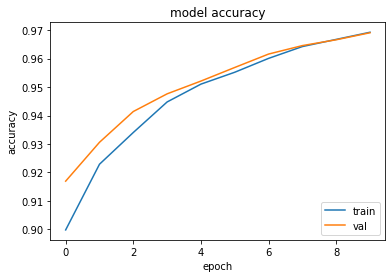

In [228]:
plot_accuracy(baseline_training)

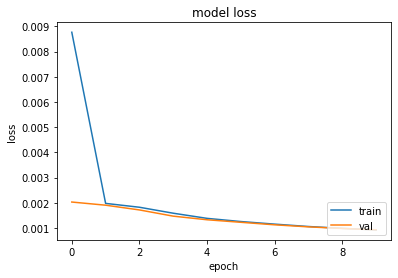

In [229]:
plot_loss(baseline_training)

In [230]:
baseline_model.save_weights('models/baseline_model_weights.h5') #Save model

## Other models

#### Gru

In [231]:
def create_gru_model(units_gru, activation):
    gru_model = keras.Sequential()
    gru_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False
                                ))
    gru_model.add(layers.Bidirectional(layers.GRU(units_gru, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    gru_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return gru_model

In [232]:
gru_model = create_gru_model(64, 'softmax')
gru_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 249, 50)           535900    
                                                                 
 bidirectional_9 (Bidirectio  (None, 249, 128)         44544     
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 249, 46)           5934      
                                                                 
Total params: 586,378
Trainable params: 50,478
Non-trainable params: 535,900
_________________________________________________________________


In [233]:
gru_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
gru_training = gru_model.fit(x=x_train, batch_size=25, y=y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
75/75 [==============================] - 17s 173ms/step - loss: 0.0102 - mae: 0.0212 - acc: 0.9133 - val_loss: 0.0019 - val_mae: 0.0040 - val_acc: 0.9273
Epoch 2/10
75/75 [==============================] - 9s 115ms/step - loss: 0.0018 - mae: 0.0037 - acc: 0.9338 - val_loss: 0.0016 - val_mae: 0.0034 - val_acc: 0.9420
Epoch 3/10
75/75 [==============================] - 10s 135ms/step - loss: 0.0015 - mae: 0.0032 - acc: 0.9476 - val_loss: 0.0014 - val_mae: 0.0030 - val_acc: 0.9514
Epoch 4/10
75/75 [==============================] - 10s 136ms/step - loss: 0.0013 - mae: 0.0028 - acc: 0.9558 - val_loss: 0.0012 - val_mae: 0.0026 - val_acc: 0.9587
Epoch 5/10
75/75 [==============================] - 15s 202ms/step - loss: 0.0011 - mae: 0.0025 - acc: 0.9625 - val_loss: 0.0011 - val_mae: 0.0024 - val_acc: 0.9639
Epoch 6/10
75/75 [==============================] - 10s 128ms/step - loss: 9.9317e-04 - mae: 0.0022 - acc: 0.9674 - val_loss: 9.8567e-04 - val_mae: 0.0021 - val_acc: 0.9673
Epo

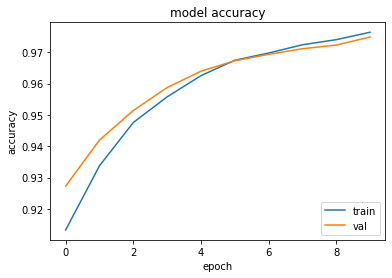

In [234]:
plot_accuracy(gru_training)

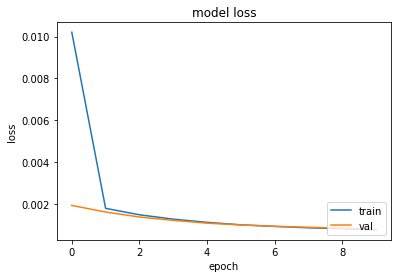

In [235]:
plot_loss(gru_training)

In [236]:
gru_model.save_weights('models/gru_model_weights.h5') #Save model

#### Two LSTM layers

In [237]:
def create_doubleLSTM_model(units_LSTM1, units_LSTM2, activation):
    doubleLSTM_model = keras.Sequential()
    doubleLSTM_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False
                                ))
    doubleLSTM_model.add(layers.Bidirectional(layers.LSTM(units_LSTM1, return_sequences=True)))
    doubleLSTM_model.add(layers.Bidirectional(layers.LSTM(units_LSTM2, return_sequences=True)))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    doubleLSTM_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return doubleLSTM_model

In [238]:
doubleLSTM_model = create_doubleLSTM_model(64, 64, 'softmax')
doubleLSTM_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 249, 50)           535900    
                                                                 
 bidirectional_10 (Bidirecti  (None, 249, 128)         58880     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 249, 128)         98816     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 249, 46)           5934      
                                                                 
Total params: 699,530
Trainable params: 163,630
Non-trainable params: 535,900
_________________________________________________________________


In [239]:
doubleLSTM_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
doubleLSTM_training = doubleLSTM_model.fit(x=x_train, batch_size=25, y=y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
75/75 [==============================] - 30s 337ms/step - loss: 0.0067 - mae: 0.0141 - acc: 0.9020 - val_loss: 0.0020 - val_mae: 0.0043 - val_acc: 0.9158
Epoch 2/10
75/75 [==============================] - 22s 299ms/step - loss: 0.0020 - mae: 0.0042 - acc: 0.9143 - val_loss: 0.0020 - val_mae: 0.0041 - val_acc: 0.9162
Epoch 3/10
75/75 [==============================] - 27s 357ms/step - loss: 0.0020 - mae: 0.0041 - acc: 0.9179 - val_loss: 0.0019 - val_mae: 0.0040 - val_acc: 0.9201
Epoch 4/10
75/75 [==============================] - 24s 322ms/step - loss: 0.0019 - mae: 0.0039 - acc: 0.9254 - val_loss: 0.0019 - val_mae: 0.0038 - val_acc: 0.9282
Epoch 5/10
75/75 [==============================] - 29s 394ms/step - loss: 0.0017 - mae: 0.0036 - acc: 0.9370 - val_loss: 0.0016 - val_mae: 0.0034 - val_acc: 0.9443
Epoch 6/10
75/75 [==============================] - 22s 291ms/step - loss: 0.0014 - mae: 0.0031 - acc: 0.9489 - val_loss: 0.0014 - val_mae: 0.0029 - val_acc: 0.9496
Epoch 7/10

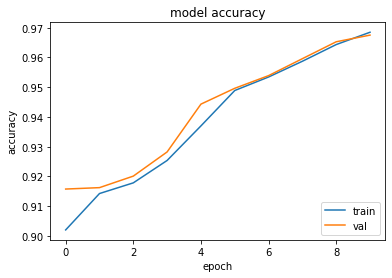

In [240]:
plot_accuracy(doubleLSTM_training)

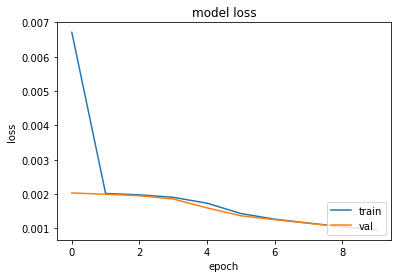

In [241]:
plot_loss(doubleLSTM_training)

In [242]:
doubleLSTM_model.save_weights('models/doubleLSTM_model_weights.h5') #Save model

#### Two dense layers

In [243]:
def create_doubledense_model(units_LSTM, units_dense, activation):
    doubledense_model = keras.Sequential()
    doubledense_model.add(layers.Embedding(input_dim = VOCABULARY_SIZE,
                                 output_dim    = embedding_dimension,
                                 input_length  = find_max_length(x_train),
                                 weights       = [embedding_matrix],
                                 trainable = False
                                ))
    doubledense_model.add(layers.Bidirectional(layers.LSTM(units_LSTM, return_sequences=True)))
    doubledense_model.add(layers.Dense(units_dense))
    #bidirect_model.add(layers.TimeDistributed(layers.Dense(len(tag_to_idx), activation='softmax')))
    doubledense_model.add(layers.Dense(TAG_VOCABULARY_SIZE, activation=activation))
    
    return doubledense_model

In [244]:
doubleDense_model = create_doubledense_model(64, 64, 'softmax')
doubleDense_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 249, 50)           535900    
                                                                 
 bidirectional_12 (Bidirecti  (None, 249, 128)         58880     
 onal)                                                           
                                                                 
 dense_11 (Dense)            (None, 249, 64)           8256      
                                                                 
 dense_12 (Dense)            (None, 249, 46)           2990      
                                                                 
Total params: 606,026
Trainable params: 70,126
Non-trainable params: 535,900
_________________________________________________________________


In [245]:
doubleDense_model.compile(loss="mse",
              optimizer="Adam",
              metrics=['mae', "acc"])
doubleDense_training = doubleDense_model.fit(x=x_train, batch_size=25, y=y_train, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
75/75 [==============================] - 18s 178ms/step - loss: 0.0075 - mae: 0.0154 - acc: 0.9052 - val_loss: 0.0020 - val_mae: 0.0040 - val_acc: 0.9206
Epoch 2/10
75/75 [==============================] - 12s 161ms/step - loss: 0.0019 - mae: 0.0040 - acc: 0.9243 - val_loss: 0.0018 - val_mae: 0.0038 - val_acc: 0.9334
Epoch 3/10
75/75 [==============================] - 10s 135ms/step - loss: 0.0017 - mae: 0.0035 - acc: 0.9414 - val_loss: 0.0015 - val_mae: 0.0031 - val_acc: 0.9470
Epoch 4/10
75/75 [==============================] - 9s 117ms/step - loss: 0.0013 - mae: 0.0029 - acc: 0.9522 - val_loss: 0.0013 - val_mae: 0.0027 - val_acc: 0.9544
Epoch 5/10
75/75 [==============================] - 9s 115ms/step - loss: 0.0012 - mae: 0.0025 - acc: 0.9590 - val_loss: 0.0011 - val_mae: 0.0024 - val_acc: 0.9609
Epoch 6/10
75/75 [==============================] - 9s 116ms/step - loss: 0.0010 - mae: 0.0023 - acc: 0.9650 - val_loss: 0.0010 - val_mae: 0.0022 - val_acc: 0.9658
Epoch 7/10
75

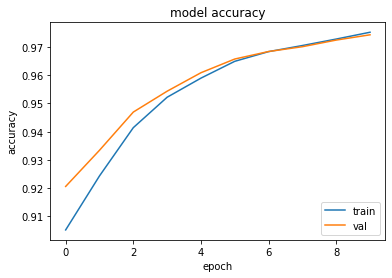

In [246]:
plot_accuracy(doubleDense_training)

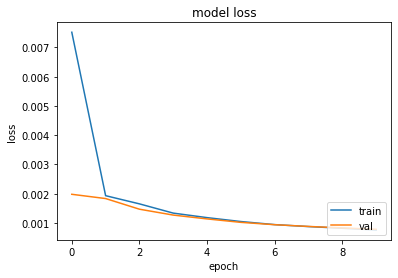

In [247]:
plot_loss(doubleDense_training)

In [248]:
doubleDense_model.save_weights('models/doubleDense_model_weights.h5') #Save model

## Predict

In [249]:
def predict(model: keras.Model, x, predicting_info):
    predictions = model.predict(x, **predicting_info)
    return predictions

In [250]:
predictions = predict(baseline_model, x_test, {'batch_size': 64})

## Evaluate

In [251]:
y_pred_bool = np.argmax(predictions, axis=2)

In [217]:
ct = to_categorical(y_test, num_classes=TAG_VOCABULARY_SIZE)
cp = to_categorical(y_pred_bool, num_classes=TAG_VOCABULARY_SIZE)

In [224]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model
print(precision_m(ct, cp))
print(f1_m(ct, cp))
print(recall_m(ct, cp))


tf.Tensor(0.9759369, shape=(), dtype=float32)
tf.Tensor(0.97593683, shape=(), dtype=float32)
tf.Tensor(0.9759369, shape=(), dtype=float32)
